# Long Short-Term Memory (LSTM)

Las redes LSTM son muy eficientes para datos secuenciales, donde el orden importa. Piensa en texto (una secuencia de palabras), series temporales (precios de acciones a lo largo del tiempo o temperatura) o audio.

Tienen un "estado interno" o "memoria" que se actualiza en cada paso de la secuencia. Esto les permite recordar información de pasos anteriores para tomar decisiones en el presente. 

Ejemplos: Predecir la siguiente palabra en una oración, clasificar el sentimiento de una reseña de película, o predecir el clima de mañana basándose en los datos de la última semana.

### Dataset
Crearemos uno: una simple onda senoidal. Esto es ideal porque es un patrón periódico y predecible, lo que nos permite verificar visualmente si nuestro modelo está aprendiendo correctamente.

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import LeaveOneGroupOut
from tensorflow.keras import Input
import pandas as pd
import numpy as np
import tensorflow as tf

In [28]:
def create_subject_sequences(X, y, subjects, window_size=10, stride=1):
    """
    Genera secuencias tipo sliding window de largo window_size
    para cada sujeto por separado.

    Parámetros:
        X: np.ndarray de forma (N, F) con todas las muestras
        y: np.ndarray de forma (N,) con etiquetas bin. por muestra
        subjects: np.ndarray de forma (N,) con id de sujeto por muestra
        window_size: int, número de filas por secuencia
        stride: int, paso entre ventanas deslizantes

    Devuelve:
        X_seq: np.ndarray (M, window_size, F)
        y_seq: np.ndarray (M,)          -- etiqueta de la última muestra de cada ventana
        subj_seq: np.ndarray (M,)       -- id de sujeto de cada secuencia
    """
    X_seqs, y_seqs, subj_seqs = [], [], []
    for subj in np.unique(subjects):
        mask = (subjects == subj)
        X_subj = X[mask]
        y_subj = y[mask]

        # ⚠️ Normalización z-score por sujeto
        mean = np.mean(X_subj, axis=0)
        std = np.std(X_subj, axis=0)
        std[std == 0] = 1  # Evitar división por cero
        X_subj = (X_subj - mean) / std

        L = len(X_subj)
        if L < window_size:
            continue

        # ventanas con stride configurable
        for start in range(0, L - window_size + 1, stride):
            end = start + window_size
            X_seqs.append(X_subj[start:end])
            y_seqs.append(y_subj[end - 1])
            subj_seqs.append(subj)

    return np.array(X_seqs), np.array(y_seqs), np.array(subj_seqs)


In [29]:
df = pd.read_csv(r'features_30_075\features.csv', index_col=0)

In [30]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 73554
Label: 2 total: 48333
Label: 3 total: 42875
Label: 4 total: 43068
Label: 5 total: 13228


In [31]:
# Filtrar los que sean 2
df = df[df['label'] != 2]

# Reasignar las clases
df['label'] = df['label'].apply(lambda x: 0 if x in [1, 5] else 1)

In [32]:
for i in range(0, len(df['label'].unique())):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 0 total: 86782
Label: 1 total: 85943


In [33]:
feature_cols = [col for col in df.columns if col not in ['label', 'subject']]

In [34]:
X = df[feature_cols].values
y = df['label'].values
subjects = df['subject'].values

import numpy as np
import pandas as pd

df_temp = pd.DataFrame({
    'subject': np.ravel(subjects),
    'label': np.ravel(y)
})

# Contar clases únicas por sujeto
clases_por_sujeto = df_temp.groupby('subject')['label'].nunique()

# Filtrar sujetos que tienen ambas clases (0 y 1)
sujetos_validos = clases_por_sujeto[clases_por_sujeto == 2].index.tolist()

# Obtener índices válidos
indices_validos = df_temp['subject'].isin(sujetos_validos)

# Filtrar X, y, subjects
X_filtrado = X[indices_validos]
y_filtrado = y[indices_validos]
subjects_filtrados = subjects[indices_validos]

from sklearn.preprocessing import RobustScaler

# Suponiendo que ya tienes X, y, subjects
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_filtrado)

print(X_scaled.shape)  # (num_samples, seq_len, num_features)
print(y_filtrado.shape)

(137712, 52)
(137712,)


In [35]:
X_seq, y_seq, subj_seq = create_subject_sequences(X_scaled, y_filtrado, subjects_filtrados, window_size=10, stride=5)

In [36]:
print(X_seq.shape)

(27506, 10, 52)


In [37]:
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


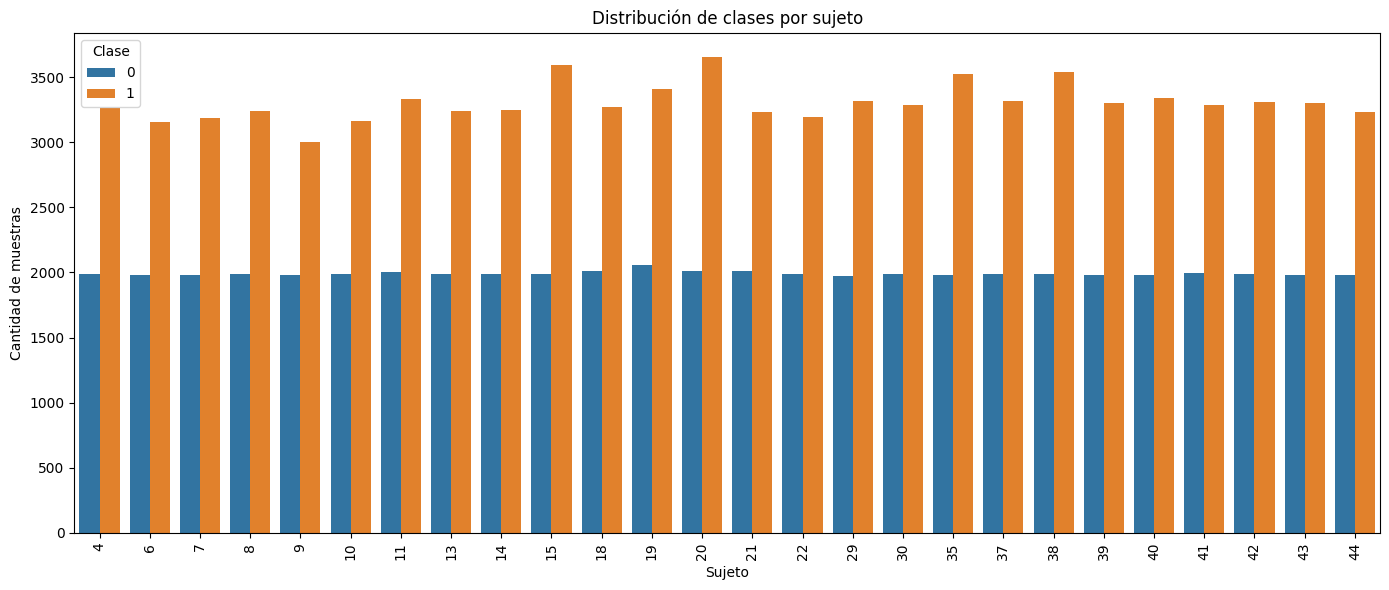

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurar que son arrays 1D
subjects_flat = np.ravel(subjects_filtrados)
y_flat = np.ravel(y_filtrado)

# Crear DataFrame temporal para análisis
df_temp = pd.DataFrame({
    'subject': subjects_flat,
    'label': y_flat
})

# Contar clases por sujeto
counts = df_temp.groupby(['subject', 'label']).size().reset_index(name='count')

# Gráfico de barras
plt.figure(figsize=(14, 6))
sns.barplot(data=counts, x='subject', y='count', hue='label')
plt.title('Distribución de clases por sujeto')
plt.xlabel('Sujeto')
plt.ylabel('Cantidad de muestras')
plt.xticks(rotation=90)
plt.legend(title='Clase')
plt.tight_layout()
plt.show()


🧪 Validando grupo 1 de 37
Clases en test (sujeto 1): {0: 396, 1: 652}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6055 - accuracy: 0.7250 - val_loss: 0.5334 - val_accuracy: 0.8693

Epoch 00001: val_accuracy improved from -inf to 0.86927, saving model to modelos\mejor_modelo_1.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5183 - accuracy: 0.8048 - val_loss: 0.4607 - val_accuracy: 0.8874

Epoch 00002: val_accuracy improved from 0.86927 to 0.88740, saving model to modelos\mejor_modelo_1.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.4493 - accuracy: 0.8413 - val_loss: 0.4072 - val_accuracy: 0.8865

Epoch 00003: val_accuracy did not improve from 0.88740
Epoch 4/50
414/414 [==============================] - 1s 3ms/step - loss: 0.3923 - accuracy: 0.8667 - val_loss: 0.3690 - val_accuracy: 0.8836

Epoch 00004: val_accuracy did not improve from 0.88740
Epoch 5/50
414/414 [==========================

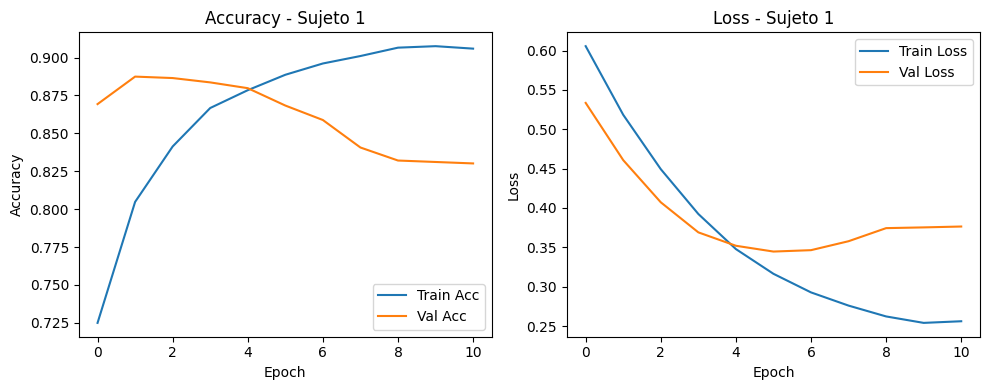

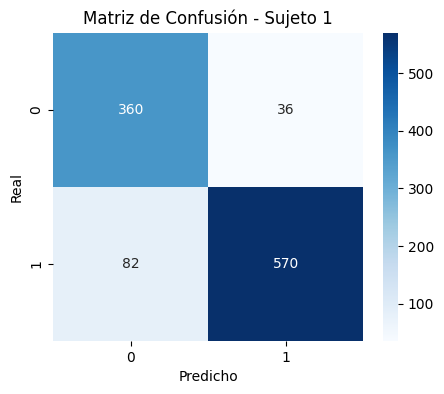

📄 Reporte de clasificación - Sujeto 1
              precision    recall  f1-score   support

           0     0.8145    0.9091    0.8592       396
           1     0.9406    0.8742    0.9062       652

    accuracy                         0.8874      1048
   macro avg     0.8775    0.8917    0.8827      1048
weighted avg     0.8929    0.8874    0.8884      1048


🧪 Validando grupo 2 de 37
Clases en test (sujeto 2): {0: 395, 1: 631}
Epoch 1/50
414/414 [==============================] - 3s 4ms/step - loss: 0.6612 - accuracy: 0.6157 - val_loss: 0.6283 - val_accuracy: 0.7144

Epoch 00001: val_accuracy improved from -inf to 0.71442, saving model to modelos\mejor_modelo_2.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5882 - accuracy: 0.7161 - val_loss: 0.5625 - val_accuracy: 0.8021

Epoch 00002: val_accuracy improved from 0.71442 to 0.80214, saving model to modelos\mejor_modelo_2.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5

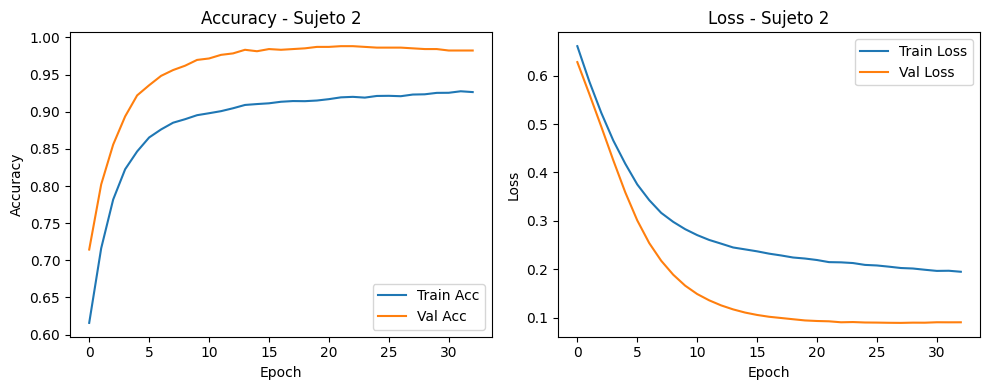

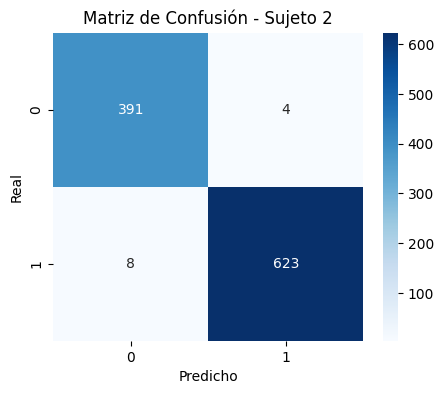

📄 Reporte de clasificación - Sujeto 2
              precision    recall  f1-score   support

           0     0.9799    0.9899    0.9849       395
           1     0.9936    0.9873    0.9905       631

    accuracy                         0.9883      1026
   macro avg     0.9868    0.9886    0.9877      1026
weighted avg     0.9884    0.9883    0.9883      1026


🧪 Validando grupo 3 de 37
Clases en test (sujeto 3): {0: 394, 1: 637}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6897 - accuracy: 0.5446 - val_loss: 0.6566 - val_accuracy: 0.6634

Epoch 00001: val_accuracy improved from -inf to 0.66343, saving model to modelos\mejor_modelo_3.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6092 - accuracy: 0.6781 - val_loss: 0.5823 - val_accuracy: 0.7692

Epoch 00002: val_accuracy improved from 0.66343 to 0.76916, saving model to modelos\mejor_modelo_3.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5

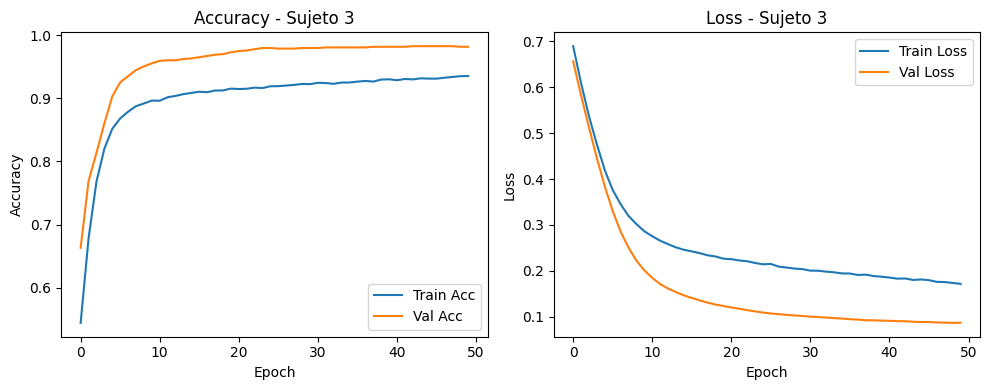

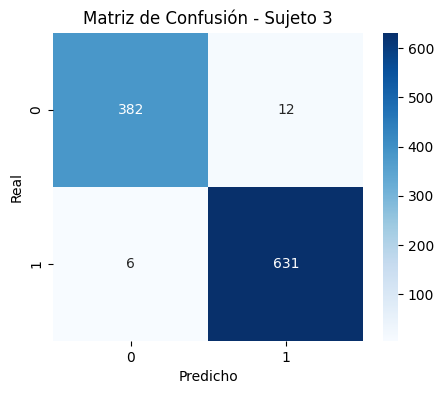

📄 Reporte de clasificación - Sujeto 3
              precision    recall  f1-score   support

           0     0.9845    0.9695    0.9770       394
           1     0.9813    0.9906    0.9859       637

    accuracy                         0.9825      1031
   macro avg     0.9829    0.9801    0.9815      1031
weighted avg     0.9826    0.9825    0.9825      1031


🧪 Validando grupo 4 de 37
Clases en test (sujeto 4): {0: 396, 1: 648}
Epoch 1/50
414/414 [==============================] - 3s 4ms/step - loss: 0.6896 - accuracy: 0.5645 - val_loss: 0.6352 - val_accuracy: 0.7136

Epoch 00001: val_accuracy improved from -inf to 0.71360, saving model to modelos\mejor_modelo_4.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6278 - accuracy: 0.6715 - val_loss: 0.5864 - val_accuracy: 0.7720

Epoch 00002: val_accuracy improved from 0.71360 to 0.77203, saving model to modelos\mejor_modelo_4.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5

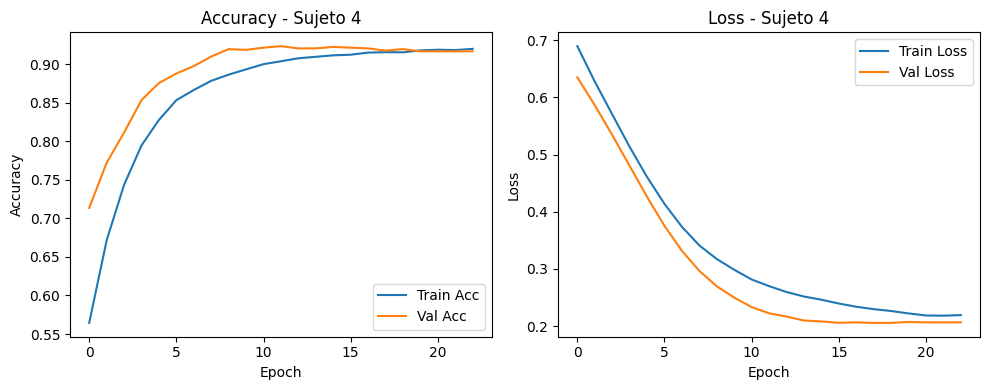

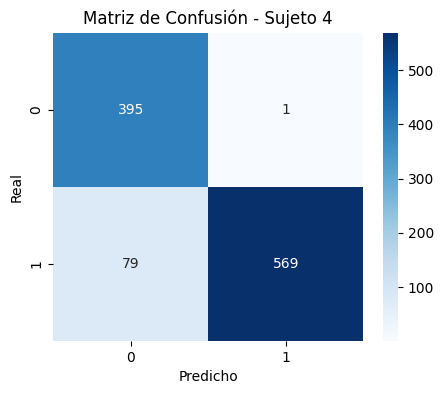

📄 Reporte de clasificación - Sujeto 4
              precision    recall  f1-score   support

           0     0.8333    0.9975    0.9080       396
           1     0.9982    0.8781    0.9343       648

    accuracy                         0.9234      1044
   macro avg     0.9158    0.9378    0.9212      1044
weighted avg     0.9357    0.9234    0.9244      1044


🧪 Validando grupo 5 de 37
Clases en test (sujeto 5): {0: 395, 1: 600}
Epoch 1/50
415/415 [==============================] - 2s 4ms/step - loss: 0.7105 - accuracy: 0.5100 - val_loss: 0.6361 - val_accuracy: 0.7588

Epoch 00001: val_accuracy improved from -inf to 0.75879, saving model to modelos\mejor_modelo_5.h5
Epoch 2/50
415/415 [==============================] - 1s 3ms/step - loss: 0.6365 - accuracy: 0.6521 - val_loss: 0.5538 - val_accuracy: 0.8884

Epoch 00002: val_accuracy improved from 0.75879 to 0.88844, saving model to modelos\mejor_modelo_5.h5
Epoch 3/50
415/415 [==============================] - 1s 3ms/step - loss: 0.5

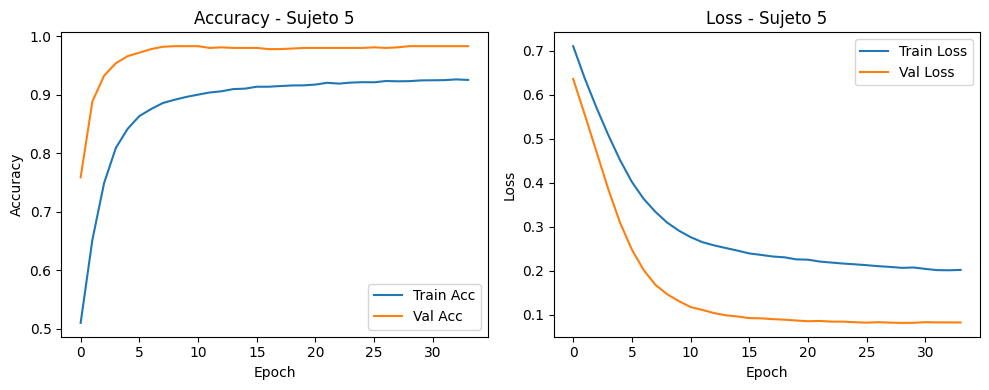

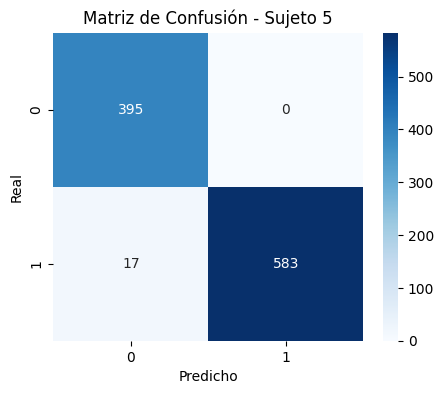

📄 Reporte de clasificación - Sujeto 5
              precision    recall  f1-score   support

           0     0.9587    1.0000    0.9789       395
           1     1.0000    0.9717    0.9856       600

    accuracy                         0.9829       995
   macro avg     0.9794    0.9858    0.9823       995
weighted avg     0.9836    0.9829    0.9830       995


🧪 Validando grupo 6 de 37
Clases en test (sujeto 6): {0: 396, 1: 632}
Epoch 1/50
414/414 [==============================] - 3s 4ms/step - loss: 0.6867 - accuracy: 0.5356 - val_loss: 0.6725 - val_accuracy: 0.5992

Epoch 00001: val_accuracy improved from -inf to 0.59922, saving model to modelos\mejor_modelo_6.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6061 - accuracy: 0.6722 - val_loss: 0.6179 - val_accuracy: 0.7403

Epoch 00002: val_accuracy improved from 0.59922 to 0.74027, saving model to modelos\mejor_modelo_6.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5

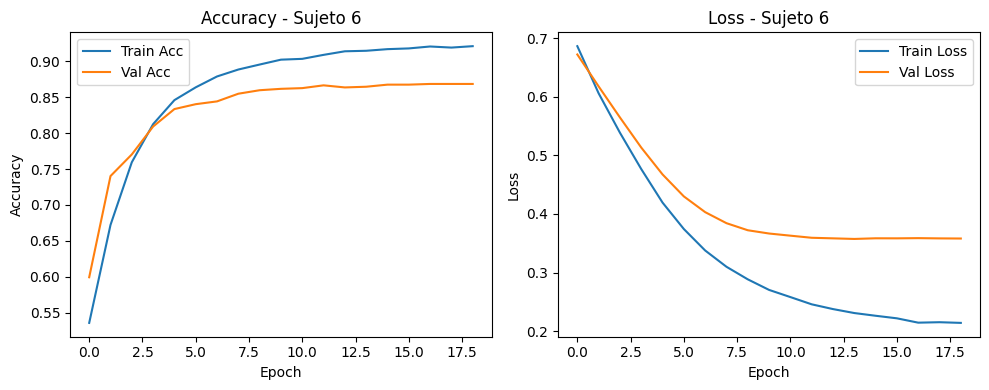

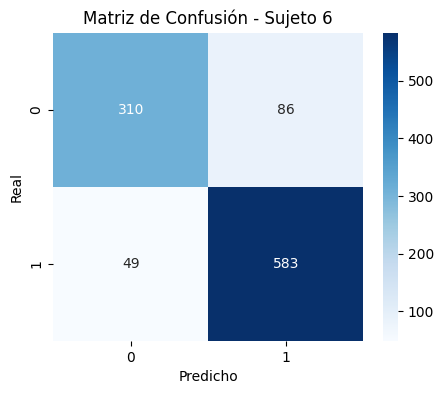

📄 Reporte de clasificación - Sujeto 6
              precision    recall  f1-score   support

           0     0.8635    0.7828    0.8212       396
           1     0.8714    0.9225    0.8962       632

    accuracy                         0.8687      1028
   macro avg     0.8675    0.8526    0.8587      1028
weighted avg     0.8684    0.8687    0.8673      1028


🧪 Validando grupo 7 de 37
Clases en test (sujeto 7): {0: 399, 1: 666}
Epoch 1/50
414/414 [==============================] - 3s 4ms/step - loss: 0.6545 - accuracy: 0.6306 - val_loss: 0.5949 - val_accuracy: 0.7793

Epoch 00001: val_accuracy improved from -inf to 0.77934, saving model to modelos\mejor_modelo_7.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5875 - accuracy: 0.7314 - val_loss: 0.5313 - val_accuracy: 0.8216

Epoch 00002: val_accuracy improved from 0.77934 to 0.82160, saving model to modelos\mejor_modelo_7.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5

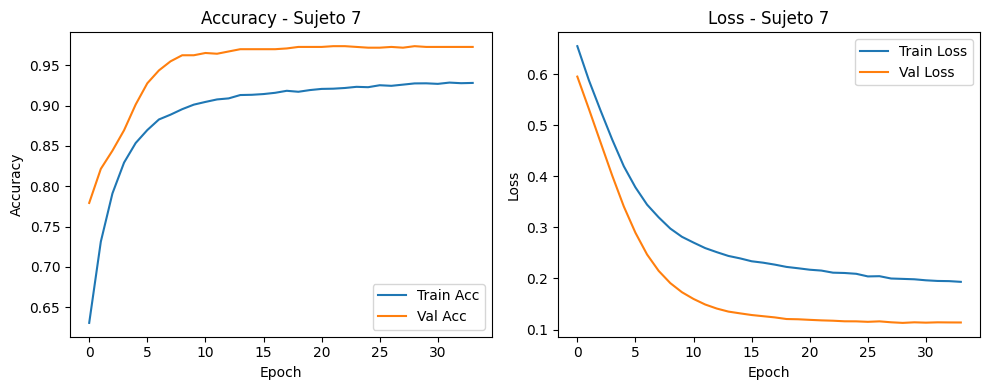

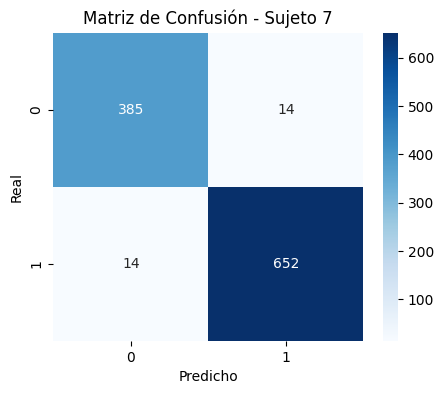

📄 Reporte de clasificación - Sujeto 7
              precision    recall  f1-score   support

           0     0.9649    0.9649    0.9649       399
           1     0.9790    0.9790    0.9790       666

    accuracy                         0.9737      1065
   macro avg     0.9719    0.9719    0.9719      1065
weighted avg     0.9737    0.9737    0.9737      1065


🧪 Validando grupo 8 de 37
Clases en test (sujeto 8): {0: 396, 1: 647}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6810 - accuracy: 0.5814 - val_loss: 0.5964 - val_accuracy: 0.8198

Epoch 00001: val_accuracy improved from -inf to 0.81975, saving model to modelos\mejor_modelo_8.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6160 - accuracy: 0.6874 - val_loss: 0.5278 - val_accuracy: 0.8514

Epoch 00002: val_accuracy improved from 0.81975 to 0.85139, saving model to modelos\mejor_modelo_8.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5

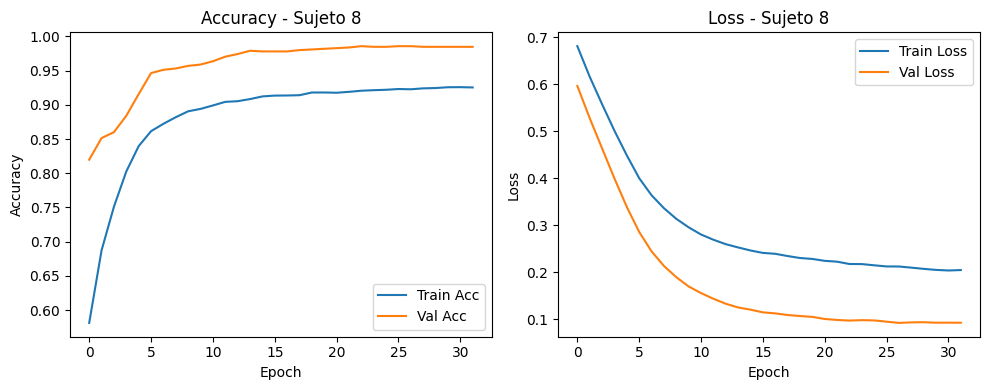

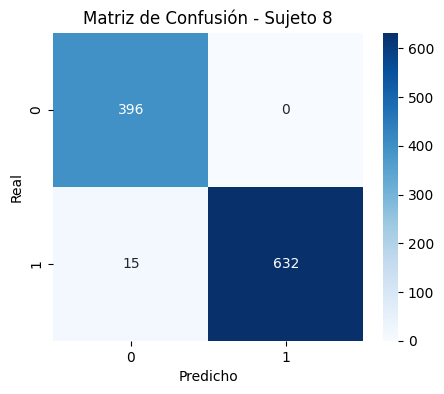

📄 Reporte de clasificación - Sujeto 8
              precision    recall  f1-score   support

           0     0.9635    1.0000    0.9814       396
           1     1.0000    0.9768    0.9883       647

    accuracy                         0.9856      1043
   macro avg     0.9818    0.9884    0.9848      1043
weighted avg     0.9861    0.9856    0.9857      1043


🧪 Validando grupo 9 de 37
Clases en test (sujeto 9): {0: 396, 1: 650}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.7180 - accuracy: 0.5020 - val_loss: 0.6936 - val_accuracy: 0.5421

Epoch 00001: val_accuracy improved from -inf to 0.54207, saving model to modelos\mejor_modelo_9.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6502 - accuracy: 0.6356 - val_loss: 0.6161 - val_accuracy: 0.7352

Epoch 00002: val_accuracy improved from 0.54207 to 0.73518, saving model to modelos\mejor_modelo_9.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5

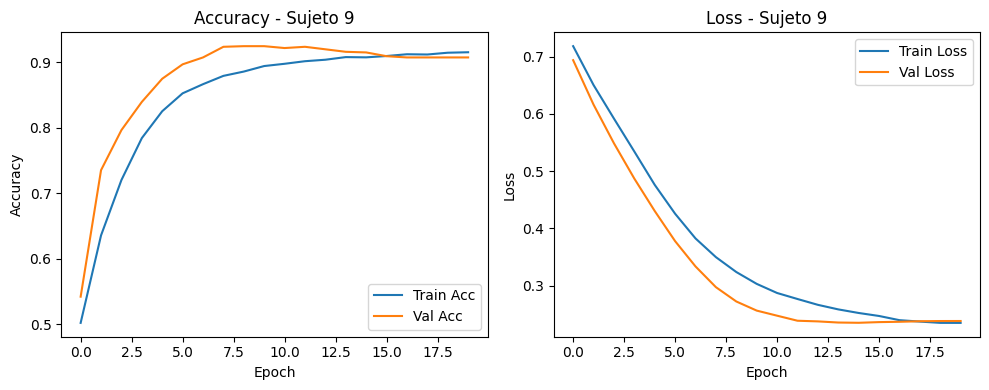

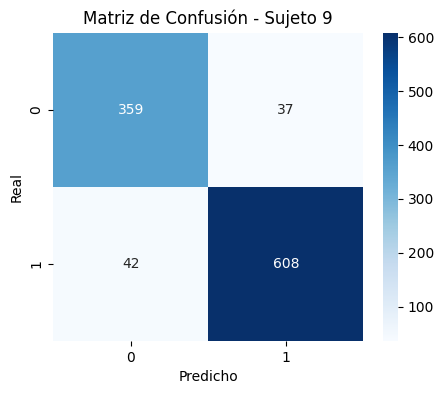

📄 Reporte de clasificación - Sujeto 9
              precision    recall  f1-score   support

           0     0.8953    0.9066    0.9009       396
           1     0.9426    0.9354    0.9390       650

    accuracy                         0.9245      1046
   macro avg     0.9189    0.9210    0.9199      1046
weighted avg     0.9247    0.9245    0.9246      1046


🧪 Validando grupo 10 de 37
Clases en test (sujeto 10): {0: 396, 1: 718}
Epoch 1/50
413/413 [==============================] - 2s 3ms/step - loss: 0.6832 - accuracy: 0.6404 - val_loss: 0.5019 - val_accuracy: 0.9183

Epoch 00001: val_accuracy improved from -inf to 0.91831, saving model to modelos\mejor_modelo_10.h5
Epoch 2/50
413/413 [==============================] - 1s 3ms/step - loss: 0.5898 - accuracy: 0.7409 - val_loss: 0.4147 - val_accuracy: 0.9587

Epoch 00002: val_accuracy improved from 0.91831 to 0.95871, saving model to modelos\mejor_modelo_10.h5
Epoch 3/50
413/413 [==============================] - 1s 3ms/step - loss:

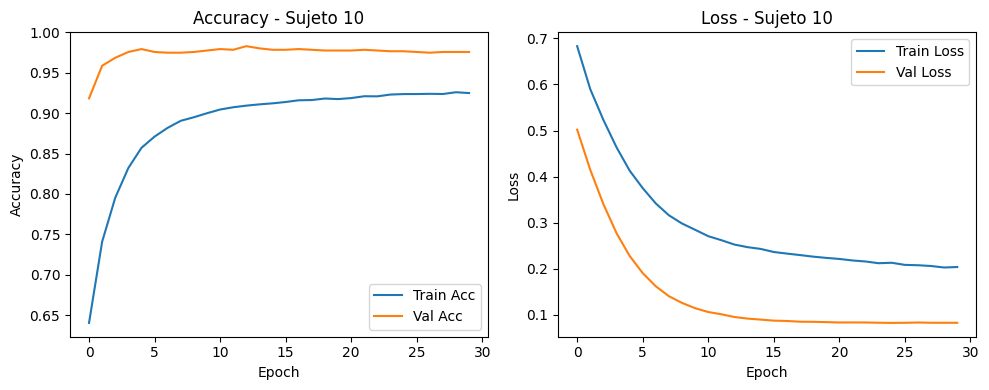

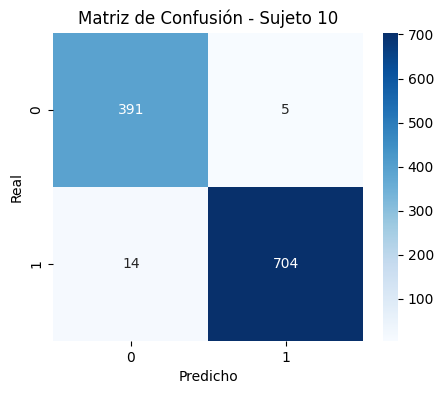

📄 Reporte de clasificación - Sujeto 10
              precision    recall  f1-score   support

           0     0.9654    0.9874    0.9763       396
           1     0.9929    0.9805    0.9867       718

    accuracy                         0.9829      1114
   macro avg     0.9792    0.9839    0.9815      1114
weighted avg     0.9832    0.9829    0.9830      1114


🧪 Validando grupo 11 de 37
Clases en test (sujeto 11): {0: 401, 1: 653}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6877 - accuracy: 0.5463 - val_loss: 0.6852 - val_accuracy: 0.5882

Epoch 00001: val_accuracy improved from -inf to 0.58824, saving model to modelos\mejor_modelo_11.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6051 - accuracy: 0.6830 - val_loss: 0.6508 - val_accuracy: 0.6480

Epoch 00002: val_accuracy improved from 0.58824 to 0.64801, saving model to modelos\mejor_modelo_11.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

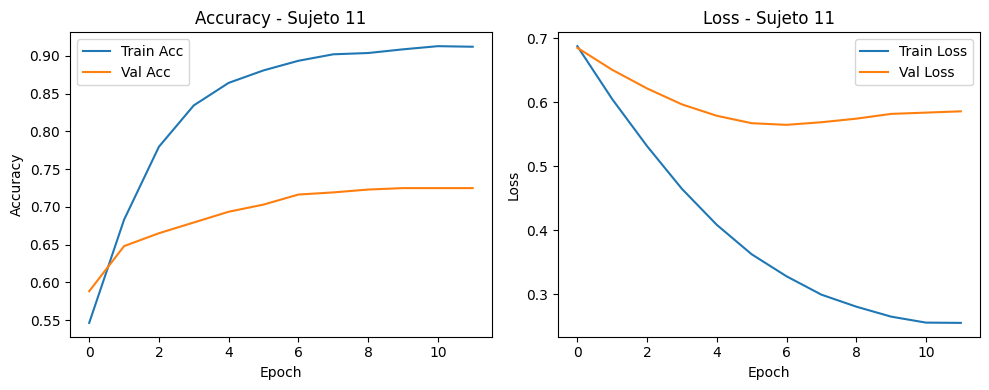

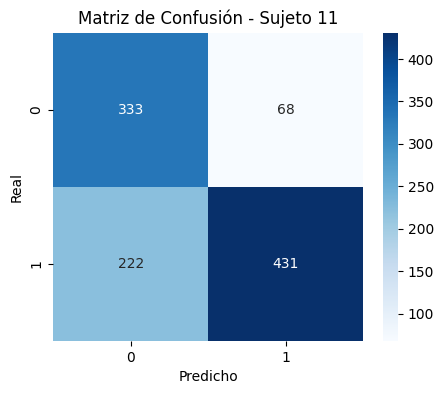

📄 Reporte de clasificación - Sujeto 11
              precision    recall  f1-score   support

           0     0.6000    0.8304    0.6967       401
           1     0.8637    0.6600    0.7483       653

    accuracy                         0.7249      1054
   macro avg     0.7319    0.7452    0.7225      1054
weighted avg     0.7634    0.7249    0.7286      1054


🧪 Validando grupo 12 de 37
Clases en test (sujeto 12): {0: 410, 1: 682}
Epoch 1/50
413/413 [==============================] - 2s 3ms/step - loss: 0.6646 - accuracy: 0.6407 - val_loss: 0.5643 - val_accuracy: 0.8782

Epoch 00001: val_accuracy improved from -inf to 0.87821, saving model to modelos\mejor_modelo_12.h5
Epoch 2/50
413/413 [==============================] - 1s 3ms/step - loss: 0.5955 - accuracy: 0.7355 - val_loss: 0.4549 - val_accuracy: 0.9744

Epoch 00002: val_accuracy improved from 0.87821 to 0.97436, saving model to modelos\mejor_modelo_12.h5
Epoch 3/50
413/413 [==============================] - 1s 3ms/step - loss

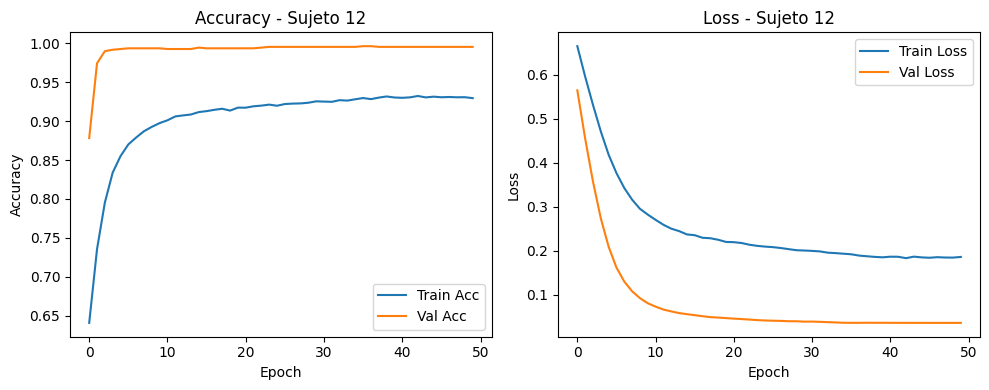

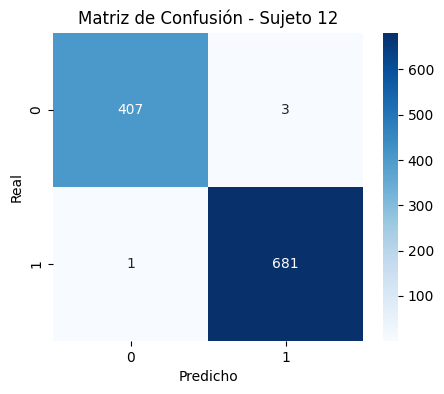

📄 Reporte de clasificación - Sujeto 12
              precision    recall  f1-score   support

           0     0.9975    0.9927    0.9951       410
           1     0.9956    0.9985    0.9971       682

    accuracy                         0.9963      1092
   macro avg     0.9966    0.9956    0.9961      1092
weighted avg     0.9963    0.9963    0.9963      1092


🧪 Validando grupo 13 de 37
Clases en test (sujeto 13): {0: 400, 1: 732}
Epoch 1/50
413/413 [==============================] - 3s 4ms/step - loss: 0.6448 - accuracy: 0.6348 - val_loss: 0.5574 - val_accuracy: 0.8428

Epoch 00001: val_accuracy improved from -inf to 0.84276, saving model to modelos\mejor_modelo_13.h5
Epoch 2/50
413/413 [==============================] - 1s 3ms/step - loss: 0.5731 - accuracy: 0.7359 - val_loss: 0.4732 - val_accuracy: 0.9311

Epoch 00002: val_accuracy improved from 0.84276 to 0.93110, saving model to modelos\mejor_modelo_13.h5
Epoch 3/50
413/413 [==============================] - 1s 3ms/step - loss

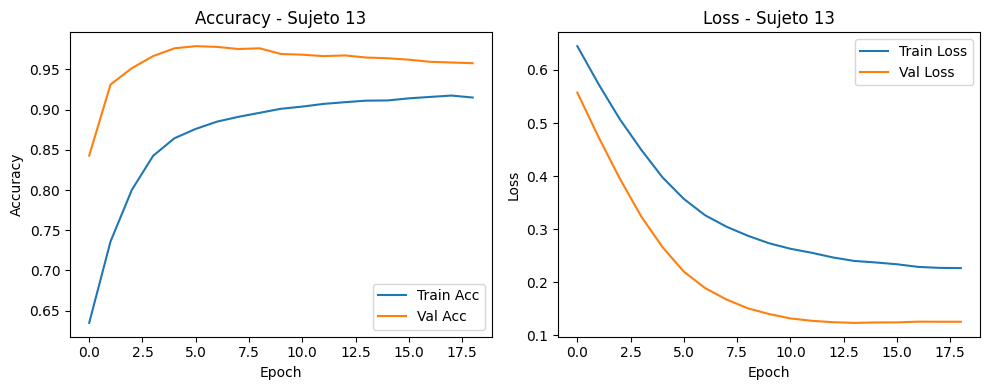

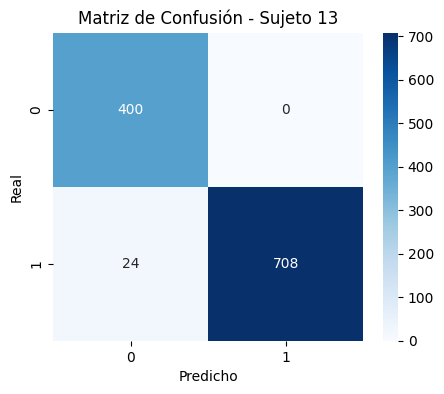

📄 Reporte de clasificación - Sujeto 13
              precision    recall  f1-score   support

           0     0.9434    1.0000    0.9709       400
           1     1.0000    0.9672    0.9833       732

    accuracy                         0.9788      1132
   macro avg     0.9717    0.9836    0.9771      1132
weighted avg     0.9800    0.9788    0.9789      1132


🧪 Validando grupo 14 de 37
Clases en test (sujeto 14): {0: 401, 1: 647}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6909 - accuracy: 0.5116 - val_loss: 0.6345 - val_accuracy: 0.6460

Epoch 00001: val_accuracy improved from -inf to 0.64599, saving model to modelos\mejor_modelo_14.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6179 - accuracy: 0.6414 - val_loss: 0.5454 - val_accuracy: 0.8406

Epoch 00002: val_accuracy improved from 0.64599 to 0.84065, saving model to modelos\mejor_modelo_14.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

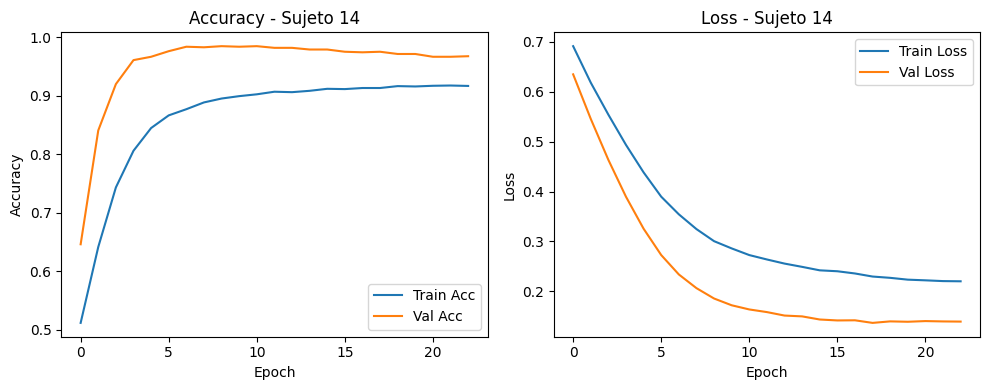

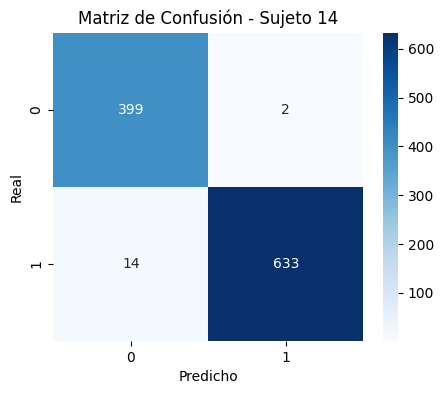

📄 Reporte de clasificación - Sujeto 14
              precision    recall  f1-score   support

           0     0.9661    0.9950    0.9803       401
           1     0.9969    0.9784    0.9875       647

    accuracy                         0.9847      1048
   macro avg     0.9815    0.9867    0.9839      1048
weighted avg     0.9851    0.9847    0.9848      1048


🧪 Validando grupo 15 de 37
Clases en test (sujeto 15): {0: 397, 1: 638}
Epoch 1/50
414/414 [==============================] - 3s 4ms/step - loss: 0.6838 - accuracy: 0.5590 - val_loss: 0.6355 - val_accuracy: 0.6995

Epoch 00001: val_accuracy improved from -inf to 0.69952, saving model to modelos\mejor_modelo_15.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5994 - accuracy: 0.7005 - val_loss: 0.5202 - val_accuracy: 0.8319

Epoch 00002: val_accuracy improved from 0.69952 to 0.83188, saving model to modelos\mejor_modelo_15.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

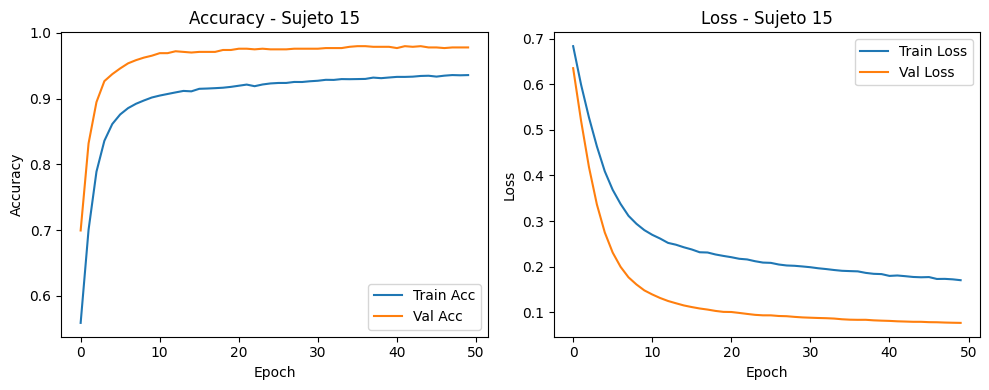

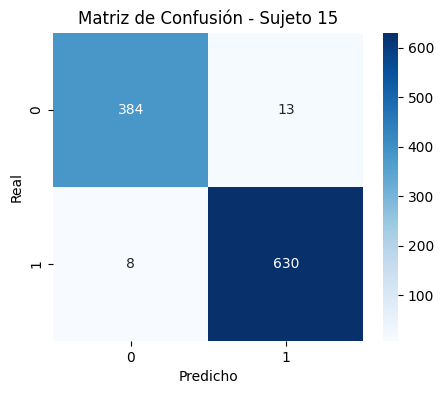

📄 Reporte de clasificación - Sujeto 15
              precision    recall  f1-score   support

           0     0.9796    0.9673    0.9734       397
           1     0.9798    0.9875    0.9836       638

    accuracy                         0.9797      1035
   macro avg     0.9797    0.9774    0.9785      1035
weighted avg     0.9797    0.9797    0.9797      1035


🧪 Validando grupo 16 de 37
Clases en test (sujeto 16): {0: 393, 1: 664}
Epoch 1/50
414/414 [==============================] - 3s 4ms/step - loss: 0.6378 - accuracy: 0.6580 - val_loss: 0.8190 - val_accuracy: 0.3633

Epoch 00001: val_accuracy improved from -inf to 0.36329, saving model to modelos\mejor_modelo_16.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5599 - accuracy: 0.7473 - val_loss: 0.8441 - val_accuracy: 0.3898

Epoch 00002: val_accuracy improved from 0.36329 to 0.38978, saving model to modelos\mejor_modelo_16.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

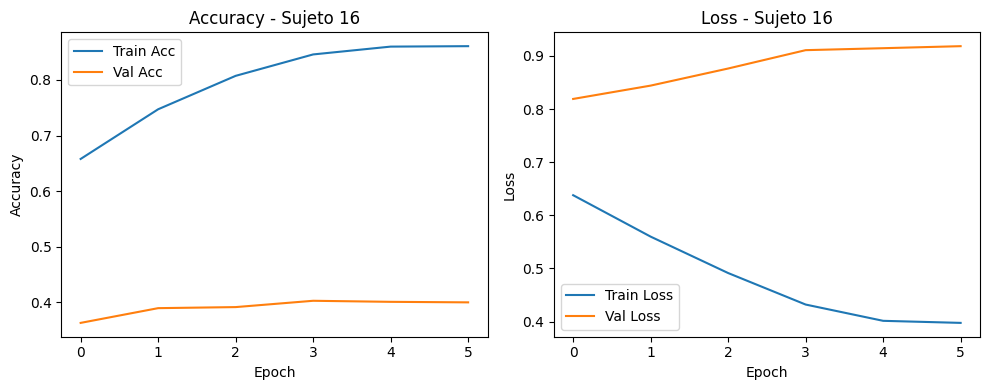

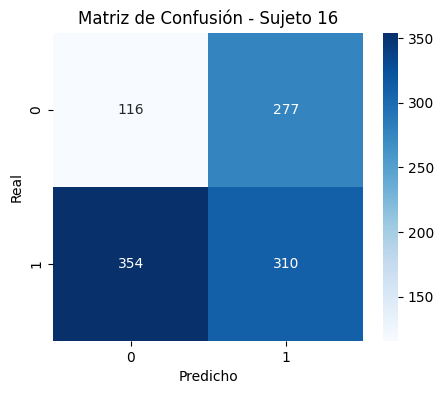

📄 Reporte de clasificación - Sujeto 16
              precision    recall  f1-score   support

           0     0.2468    0.2952    0.2688       393
           1     0.5281    0.4669    0.4956       664

    accuracy                         0.4030      1057
   macro avg     0.3875    0.3810    0.3822      1057
weighted avg     0.4235    0.4030    0.4113      1057


🧪 Validando grupo 17 de 37
Clases en test (sujeto 17): {0: 396, 1: 658}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.7281 - accuracy: 0.5928 - val_loss: 0.6519 - val_accuracy: 0.6584

Epoch 00001: val_accuracy improved from -inf to 0.65844, saving model to modelos\mejor_modelo_17.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6431 - accuracy: 0.6823 - val_loss: 0.5809 - val_accuracy: 0.7894

Epoch 00002: val_accuracy improved from 0.65844 to 0.78937, saving model to modelos\mejor_modelo_17.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

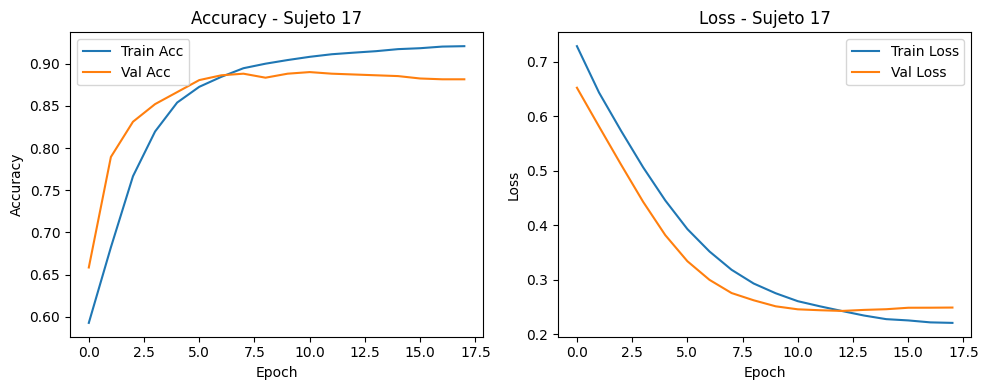

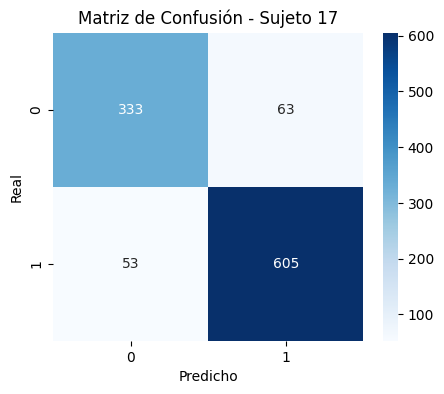

📄 Reporte de clasificación - Sujeto 17
              precision    recall  f1-score   support

           0     0.8627    0.8409    0.8517       396
           1     0.9057    0.9195    0.9125       658

    accuracy                         0.8899      1054
   macro avg     0.8842    0.8802    0.8821      1054
weighted avg     0.8895    0.8899    0.8897      1054


🧪 Validando grupo 18 de 37
Clases en test (sujeto 18): {0: 395, 1: 705}
Epoch 1/50
413/413 [==============================] - 3s 4ms/step - loss: 0.6405 - accuracy: 0.6879 - val_loss: 0.6564 - val_accuracy: 0.6355

Epoch 00001: val_accuracy improved from -inf to 0.63545, saving model to modelos\mejor_modelo_18.h5
Epoch 2/50
413/413 [==============================] - 1s 3ms/step - loss: 0.5662 - accuracy: 0.7820 - val_loss: 0.6445 - val_accuracy: 0.6473

Epoch 00002: val_accuracy improved from 0.63545 to 0.64727, saving model to modelos\mejor_modelo_18.h5
Epoch 3/50
413/413 [==============================] - 1s 3ms/step - loss

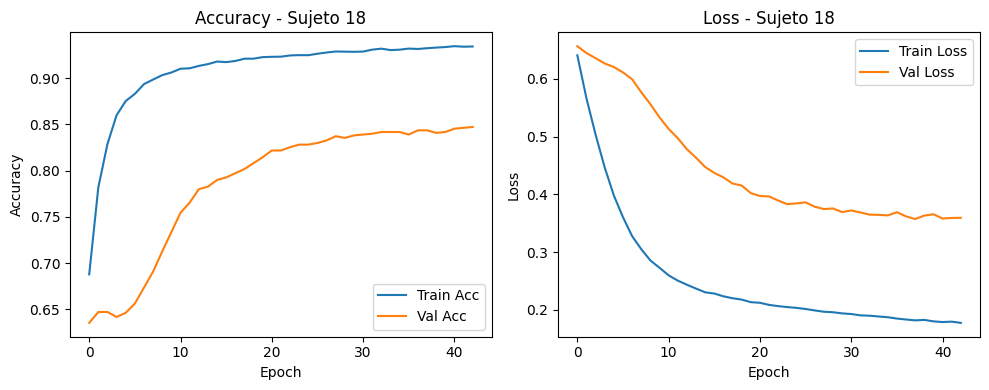

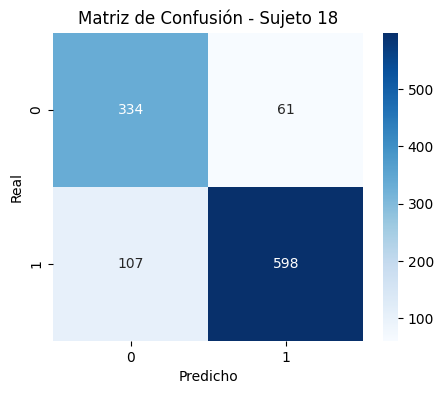

📄 Reporte de clasificación - Sujeto 18
              precision    recall  f1-score   support

           0     0.7574    0.8456    0.7990       395
           1     0.9074    0.8482    0.8768       705

    accuracy                         0.8473      1100
   macro avg     0.8324    0.8469    0.8379      1100
weighted avg     0.8535    0.8473    0.8489      1100


🧪 Validando grupo 19 de 37
Clases en test (sujeto 19): {0: 396, 1: 663}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6117 - accuracy: 0.6887 - val_loss: 0.7463 - val_accuracy: 0.5241

Epoch 00001: val_accuracy improved from -inf to 0.52408, saving model to modelos\mejor_modelo_19.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5350 - accuracy: 0.7702 - val_loss: 0.7369 - val_accuracy: 0.5685

Epoch 00002: val_accuracy improved from 0.52408 to 0.56846, saving model to modelos\mejor_modelo_19.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

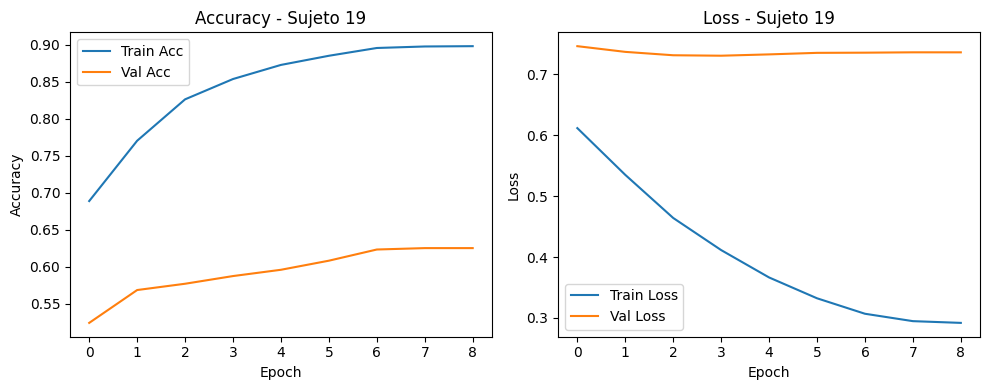

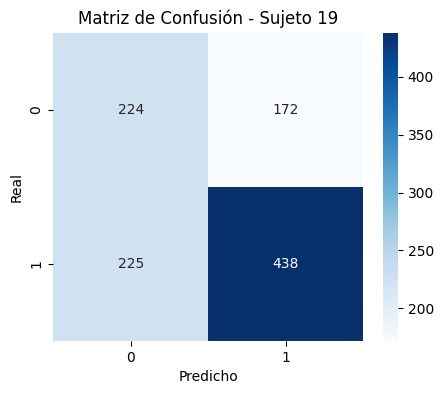

📄 Reporte de clasificación - Sujeto 19
              precision    recall  f1-score   support

           0     0.4989    0.5657    0.5302       396
           1     0.7180    0.6606    0.6881       663

    accuracy                         0.6251      1059
   macro avg     0.6085    0.6131    0.6092      1059
weighted avg     0.6361    0.6251    0.6291      1059


🧪 Validando grupo 20 de 37
Clases en test (sujeto 20): {0: 396, 1: 707}
Epoch 1/50
413/413 [==============================] - 2s 4ms/step - loss: 0.6951 - accuracy: 0.5884 - val_loss: 0.5931 - val_accuracy: 0.7824

Epoch 00001: val_accuracy improved from -inf to 0.78241, saving model to modelos\mejor_modelo_20.h5
Epoch 2/50
413/413 [==============================] - 1s 3ms/step - loss: 0.6116 - accuracy: 0.6979 - val_loss: 0.5191 - val_accuracy: 0.8377

Epoch 00002: val_accuracy improved from 0.78241 to 0.83772, saving model to modelos\mejor_modelo_20.h5
Epoch 3/50
413/413 [==============================] - 1s 3ms/step - loss

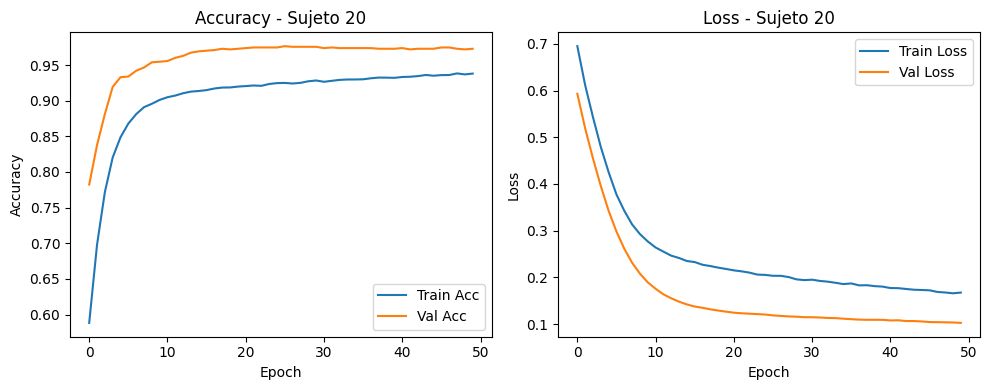

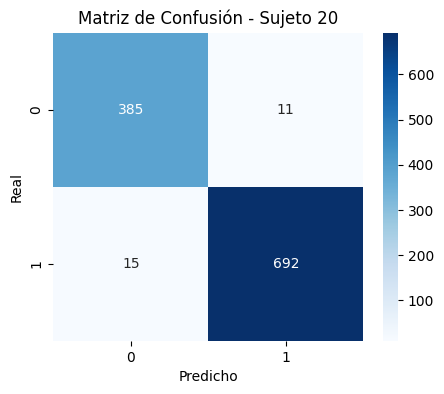

📄 Reporte de clasificación - Sujeto 20
              precision    recall  f1-score   support

           0     0.9625    0.9722    0.9673       396
           1     0.9844    0.9788    0.9816       707

    accuracy                         0.9764      1103
   macro avg     0.9734    0.9755    0.9744      1103
weighted avg     0.9765    0.9764    0.9765      1103


🧪 Validando grupo 21 de 37
Clases en test (sujeto 21): {0: 395, 1: 661}
Epoch 1/50
414/414 [==============================] - 3s 4ms/step - loss: 0.6756 - accuracy: 0.6216 - val_loss: 0.6285 - val_accuracy: 0.7737

Epoch 00001: val_accuracy improved from -inf to 0.77367, saving model to modelos\mejor_modelo_21.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6075 - accuracy: 0.7284 - val_loss: 0.5709 - val_accuracy: 0.8873

Epoch 00002: val_accuracy improved from 0.77367 to 0.88731, saving model to modelos\mejor_modelo_21.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

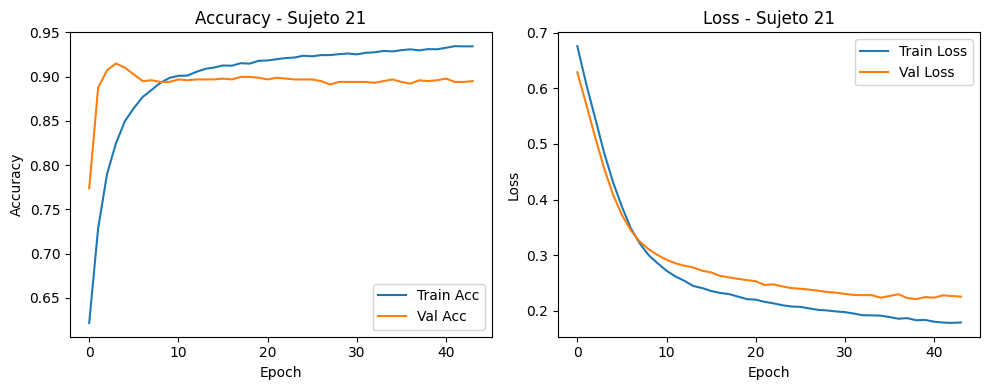

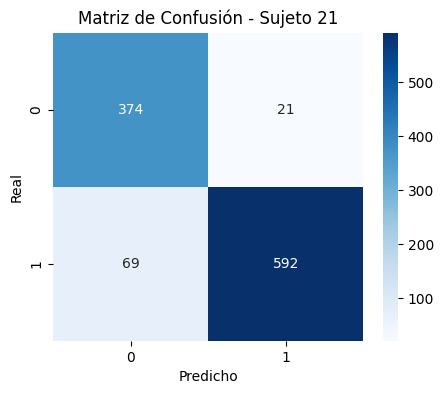

📄 Reporte de clasificación - Sujeto 21
              precision    recall  f1-score   support

           0     0.8442    0.9468    0.8926       395
           1     0.9657    0.8956    0.9294       661

    accuracy                         0.9148      1056
   macro avg     0.9050    0.9212    0.9110      1056
weighted avg     0.9203    0.9148    0.9156      1056


🧪 Validando grupo 22 de 37
Clases en test (sujeto 22): {0: 395, 1: 668}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.7103 - accuracy: 0.5758 - val_loss: 0.6074 - val_accuracy: 0.7770

Epoch 00001: val_accuracy improved from -inf to 0.77705, saving model to modelos\mejor_modelo_22.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6309 - accuracy: 0.6848 - val_loss: 0.5386 - val_accuracy: 0.8881

Epoch 00002: val_accuracy improved from 0.77705 to 0.88805, saving model to modelos\mejor_modelo_22.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

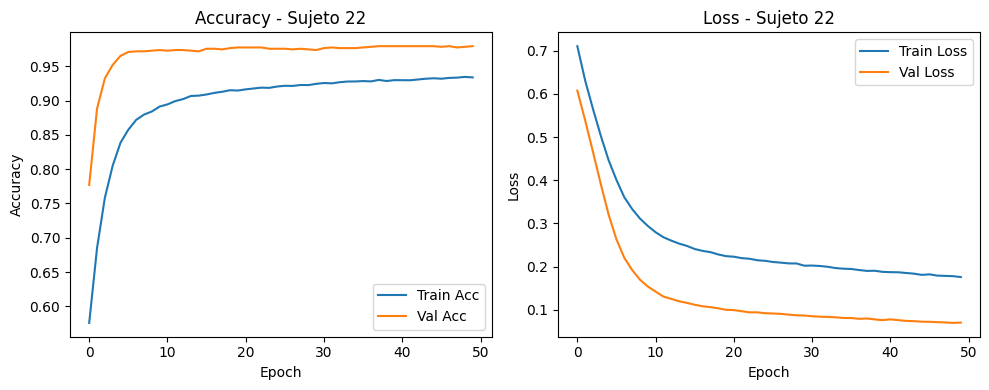

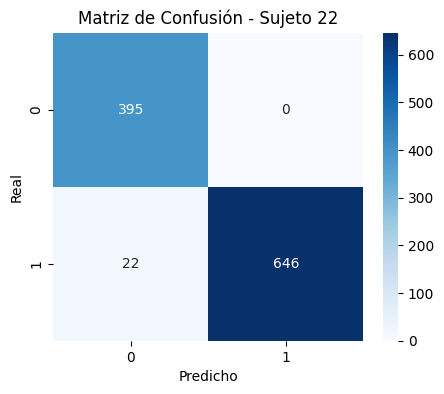

📄 Reporte de clasificación - Sujeto 22
              precision    recall  f1-score   support

           0     0.9472    1.0000    0.9729       395
           1     1.0000    0.9671    0.9833       668

    accuracy                         0.9793      1063
   macro avg     0.9736    0.9835    0.9781      1063
weighted avg     0.9804    0.9793    0.9794      1063


🧪 Validando grupo 23 de 37
Clases en test (sujeto 23): {0: 398, 1: 658}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6379 - accuracy: 0.6888 - val_loss: 0.5253 - val_accuracy: 0.8968

Epoch 00001: val_accuracy improved from -inf to 0.89678, saving model to modelos\mejor_modelo_23.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5617 - accuracy: 0.7741 - val_loss: 0.4446 - val_accuracy: 0.9527

Epoch 00002: val_accuracy improved from 0.89678 to 0.95265, saving model to modelos\mejor_modelo_23.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

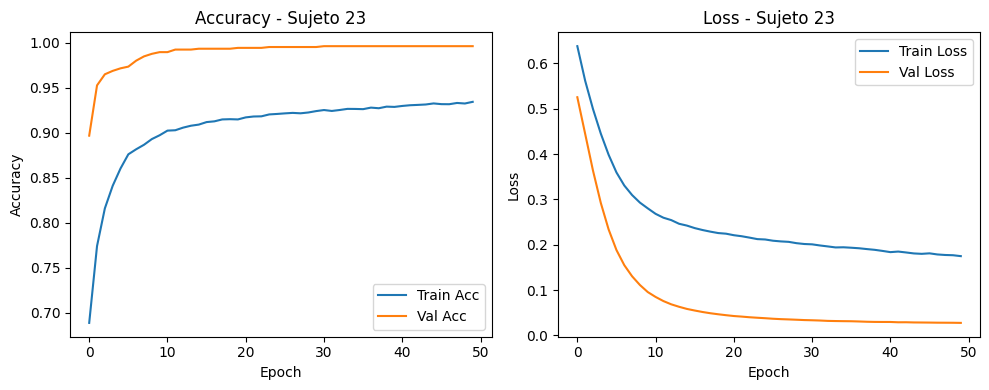

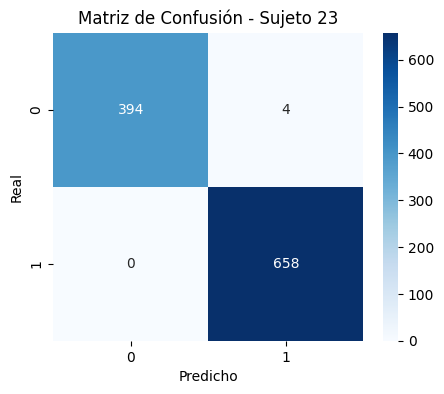

📄 Reporte de clasificación - Sujeto 23
              precision    recall  f1-score   support

           0     1.0000    0.9899    0.9949       398
           1     0.9940    1.0000    0.9970       658

    accuracy                         0.9962      1056
   macro avg     0.9970    0.9950    0.9960      1056
weighted avg     0.9962    0.9962    0.9962      1056


🧪 Validando grupo 24 de 37
Clases en test (sujeto 24): {0: 396, 1: 663}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6367 - accuracy: 0.6263 - val_loss: 0.7221 - val_accuracy: 0.4769

Epoch 00001: val_accuracy improved from -inf to 0.47686, saving model to modelos\mejor_modelo_24.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5530 - accuracy: 0.7610 - val_loss: 0.7114 - val_accuracy: 0.4759

Epoch 00002: val_accuracy did not improve from 0.47686
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.4849 - accuracy: 0.8280 - val_loss: 0.7116 -

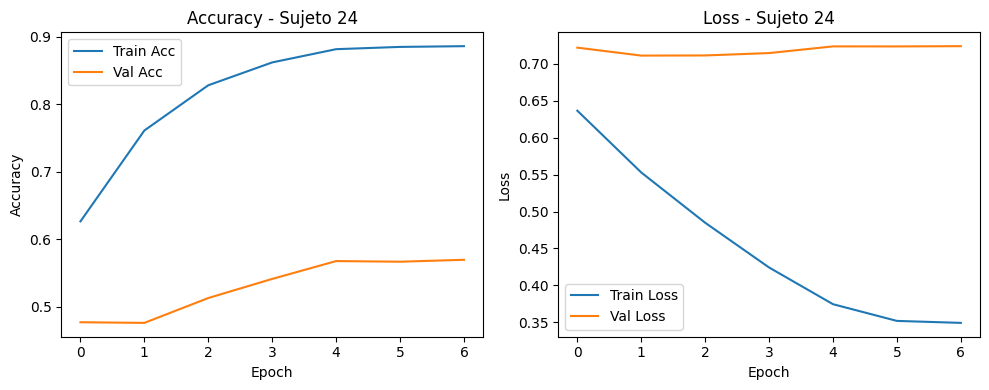

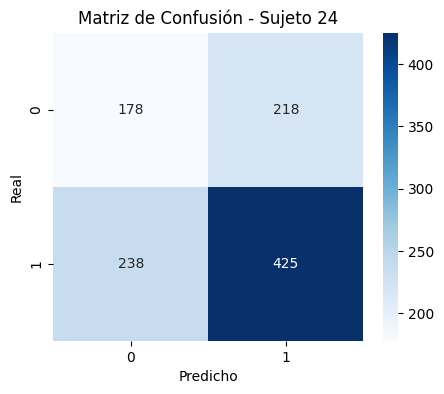

📄 Reporte de clasificación - Sujeto 24
              precision    recall  f1-score   support

           0     0.4279    0.4495    0.4384       396
           1     0.6610    0.6410    0.6508       663

    accuracy                         0.5694      1059
   macro avg     0.5444    0.5453    0.5446      1059
weighted avg     0.5738    0.5694    0.5714      1059


🧪 Validando grupo 25 de 37
Clases en test (sujeto 25): {0: 395, 1: 661}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6483 - accuracy: 0.6087 - val_loss: 0.6334 - val_accuracy: 0.6742

Epoch 00001: val_accuracy improved from -inf to 0.67424, saving model to modelos\mejor_modelo_25.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5750 - accuracy: 0.7377 - val_loss: 0.5818 - val_accuracy: 0.7509

Epoch 00002: val_accuracy improved from 0.67424 to 0.75095, saving model to modelos\mejor_modelo_25.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

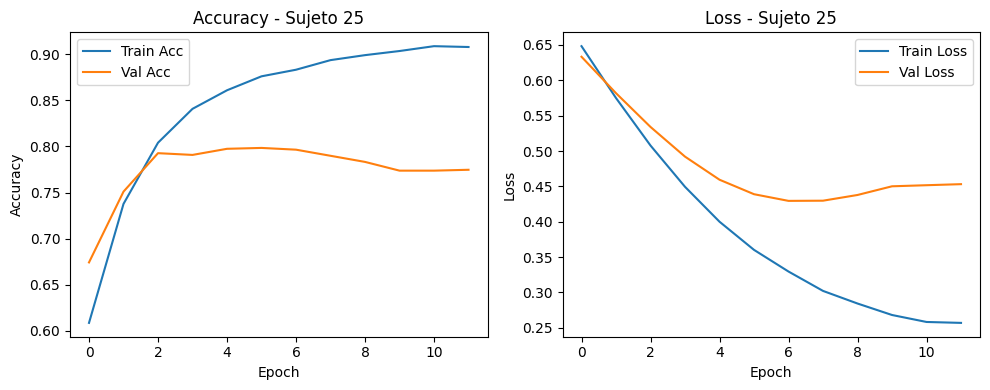

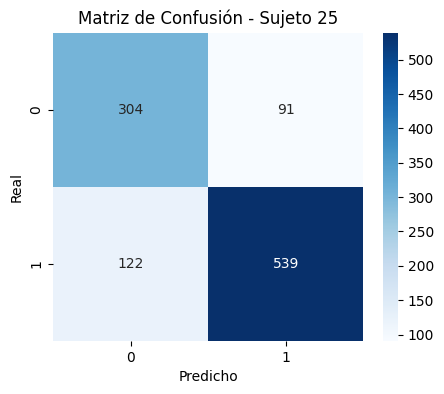

📄 Reporte de clasificación - Sujeto 25
              precision    recall  f1-score   support

           0     0.7136    0.7696    0.7406       395
           1     0.8556    0.8154    0.8350       661

    accuracy                         0.7983      1056
   macro avg     0.7846    0.7925    0.7878      1056
weighted avg     0.8025    0.7983    0.7997      1056


🧪 Validando grupo 26 de 37
Clases en test (sujeto 26): {0: 395, 1: 647}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6494 - accuracy: 0.6202 - val_loss: 0.6387 - val_accuracy: 0.6727

Epoch 00001: val_accuracy improved from -inf to 0.67274, saving model to modelos\mejor_modelo_26.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5843 - accuracy: 0.7416 - val_loss: 0.5569 - val_accuracy: 0.8033

Epoch 00002: val_accuracy improved from 0.67274 to 0.80326, saving model to modelos\mejor_modelo_26.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

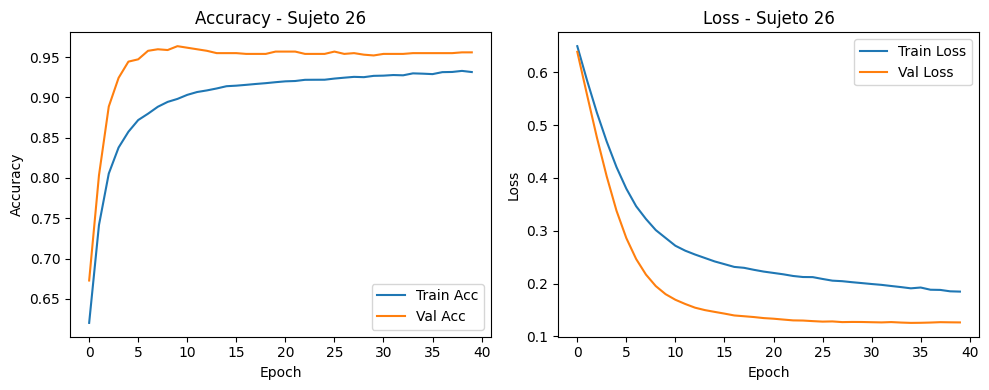

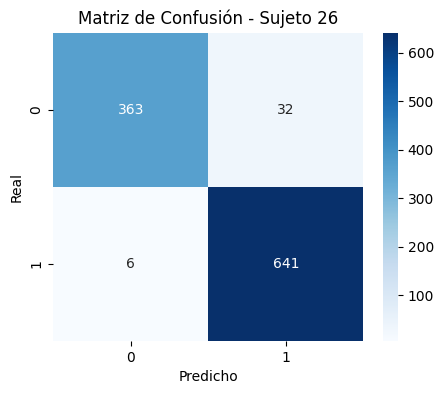

📄 Reporte de clasificación - Sujeto 26
              precision    recall  f1-score   support

           0     0.9837    0.9190    0.9503       395
           1     0.9525    0.9907    0.9712       647

    accuracy                         0.9635      1042
   macro avg     0.9681    0.9549    0.9607      1042
weighted avg     0.9643    0.9635    0.9633      1042


📊 Resultados Finales:
Promedio Accuracy: 0.8895 ± 0.1482
Promedio F1 Score: 0.9082 ± 0.1246


In [39]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D

accuracies = []
f1_scores = []

logo = LeaveOneGroupOut()
split_num = 1

for train_idx, test_idx in logo.split(X_seq, y_seq, groups=subj_seq):
    print(f"\n🧪 Validando grupo {split_num} de {len(np.unique(subjects))}")
    X_train, X_test = X_seq[train_idx], X_seq[test_idx]
    y_train, y_test = y_seq[train_idx], y_seq[test_idx]

    X_train = tf.cast(X_train, tf.float32)
    X_test = tf.cast(X_test, tf.float32)
    y_train = tf.cast(y_train, tf.int32)
    y_test = tf.cast(y_test, tf.int32)

    checkpoint = ModelCheckpoint(f"modelos/mejor_modelo_{split_num}.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=1e-8, verbose=1)
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train.numpy()), y=y_train.numpy())
    class_weight_dict = dict(zip(np.unique(y_train.numpy()), class_weights))

    unique, counts = np.unique(y_test, return_counts=True)
    print(f"Clases en test (sujeto {split_num}): {dict(zip(unique, counts))}")

    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=(10, 52)),
        MaxPooling1D(2),
        LSTM(32, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1.0e-5),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )


    with tf.device('/GPU:0'):
        history = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=64,
            validation_data=(X_test, y_test),
            callbacks=[checkpoint, reduce_lr, early_stop],
            class_weight=class_weight_dict,
            verbose=1
        )

    # Evaluar
    mejor_modelo = load_model(f"modelos/mejor_modelo_{split_num}.h5")
    loss, acc = mejor_modelo.evaluate(X_test, y_test, verbose=0)
    y_pred_prob = mejor_modelo.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    f1 = f1_score(y_test, y_pred)
    accuracies.append(acc)
    f1_scores.append(f1)

    print(f"✅ Accuracy: {acc:.4f} - F1: {f1:.4f}")

    # ----------------------
    # 🔹 CURVAS DE ENTRENAMIENTO
    # ----------------------
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy - Sujeto {split_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss - Sujeto {split_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    # plt.savefig(f'curvas_entrenamiento_sujeto_{split_num}.png')  # Guardar imagen (opcional)

    # ----------------------
    # 🔹 MATRIZ DE CONFUSIÓN Y REPORTE
    # ----------------------
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión - Sujeto {split_num}')
    plt.show()
    # plt.savefig(f'matriz_confusion_sujeto_{split_num}.png')  # Guardar imagen (opcional)

    print(f'📄 Reporte de clasificación - Sujeto {split_num}')
    print(classification_report(y_test, y_pred, digits=4))

    split_num += 1

# ----------------------
# 📊 RESULTADOS FINALES
# ----------------------
print("\n📊 Resultados Finales:")
print(f"Promedio Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Promedio F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

✅ Evaluando modelo 1
✅ Evaluando modelo 2
✅ Evaluando modelo 3
✅ Evaluando modelo 4
✅ Evaluando modelo 5
✅ Evaluando modelo 6
✅ Evaluando modelo 7
✅ Evaluando modelo 8
✅ Evaluando modelo 9
✅ Evaluando modelo 10
✅ Evaluando modelo 11
✅ Evaluando modelo 12
✅ Evaluando modelo 13
✅ Evaluando modelo 14
✅ Evaluando modelo 15
✅ Evaluando modelo 16
✅ Evaluando modelo 17
✅ Evaluando modelo 18
✅ Evaluando modelo 19
✅ Evaluando modelo 20
✅ Evaluando modelo 21
✅ Evaluando modelo 22
✅ Evaluando modelo 23
✅ Evaluando modelo 24
✅ Evaluando modelo 25
✅ Evaluando modelo 26

📊 Resultados por sujeto:
    Sujeto  Accuracy  F1 Score              Modelo  class_0  class_1
0        1    0.8874    0.9062   mejor_modelo_1.h5      396      652
1        2    0.9883    0.9905   mejor_modelo_2.h5      395      631
2        3    0.9825    0.9859   mejor_modelo_3.h5      394      637
3        4    0.9234    0.9343   mejor_modelo_4.h5      396      648
4        5    0.9829    0.9856   mejor_modelo_5.h5      395      6

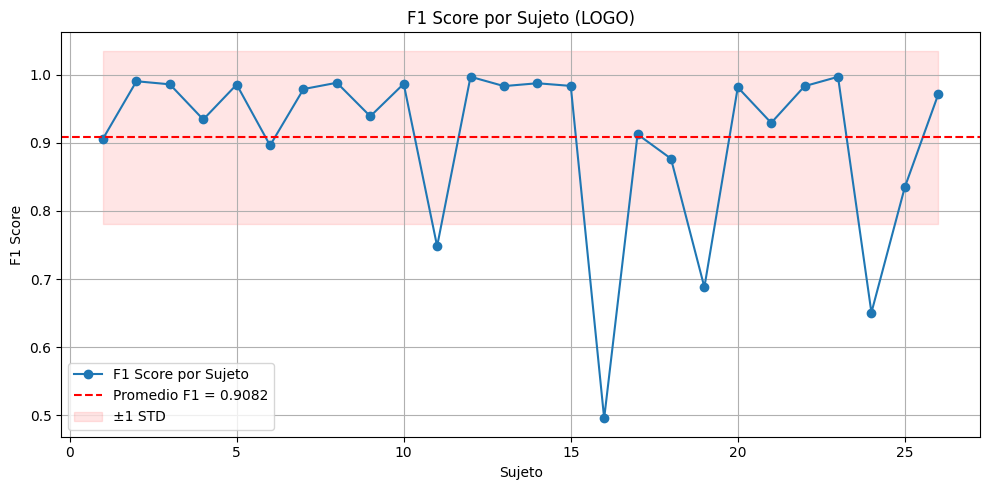


📌 Promedios generales:
Accuracy promedio: 0.8895 ± 0.1511
F1 Score promedio: 0.9082 ± 0.1271


In [40]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, accuracy_score
from tensorflow.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt

# Carpeta donde están tus modelos
MODEL_FOLDER = "modelos"
model_files = sorted([f for f in os.listdir(MODEL_FOLDER) if f.endswith(".h5")])

# Para almacenar resultados
results = []

logo = LeaveOneGroupOut()

split_num = 1
for train_idx, test_idx in logo.split(X_seq, y_seq, groups=subj_seq):
    model_path = os.path.join(MODEL_FOLDER, f"mejor_modelo_{split_num}.h5")
    if not os.path.exists(model_path):
        print(f"❌ Modelo no encontrado: {model_path}")
        split_num += 1
        continue

    print(f"✅ Evaluando modelo {split_num}")
    
    X_test = tf.cast(X_seq[test_idx], tf.float32)
    y_test = y_seq[test_idx]

    model = load_model(model_path)
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    unique, counts = np.unique(y_test, return_counts=True)
    class_dist = {f"class_{int(cls)}": int(count) for cls, count in zip(unique, counts)}

    results.append({
        "Sujeto": split_num,
        "Accuracy": acc,
        "F1 Score": f1,
        "Modelo": f"mejor_modelo_{split_num}.h5",
        **class_dist
    })

    split_num += 1

# Convertir a DataFrame
df_resultados = pd.DataFrame(results)

# -----------------------
# 🧾 Tabla resumida
# -----------------------
pd.set_option('display.float_format', lambda x: '%.4f' % x)
print("\n📊 Resultados por sujeto:")
print(df_resultados)

# -----------------------
# 📈 Gráfico resumen
# -----------------------
plt.figure(figsize=(10, 5))
plt.plot(df_resultados["Sujeto"], df_resultados["F1 Score"], marker='o', label="F1 Score por Sujeto")
plt.axhline(df_resultados["F1 Score"].mean(), color='r', linestyle='--', label=f"Promedio F1 = {df_resultados['F1 Score'].mean():.4f}")
plt.fill_between(df_resultados["Sujeto"],
                 df_resultados["F1 Score"].mean() - df_resultados["F1 Score"].std(),
                 df_resultados["F1 Score"].mean() + df_resultados["F1 Score"].std(),
                 color='r', alpha=0.1, label="±1 STD")

plt.title("F1 Score por Sujeto (LOGO)")
plt.xlabel("Sujeto")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------
# 🔢 Promedios generales
# -----------------------
print("\n📌 Promedios generales:")
print(f"Accuracy promedio: {df_resultados['Accuracy'].mean():.4f} ± {df_resultados['Accuracy'].std():.4f}")
print(f"F1 Score promedio: {df_resultados['F1 Score'].mean():.4f} ± {df_resultados['F1 Score'].std():.4f}")
